# Script for generating trait + population graphs
Plots each species in one simulation on the same graph (for comparison between species)
Prints each trait from all simulations next to each other (for comparison between different simulations)

In [1]:
export = True

In [2]:
# basic imports and reading of file
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path
import glob
import time
import json
import seaborn as sns

In [3]:
# load logs
traits = []
fcms = []
dataframes = []
fcm_dataframes = dict()

subFolders = glob.glob("Logs/*/")
for sub in subFolders:
    traits = traits + glob.glob(sub +"Traits.txt")
    fcms = fcms + glob.glob(sub + "*_fcm.txt")
for file in traits:
    dataframes.append((pd.read_csv(file), file.split('\\')[1]))
#for file in fcms:
#    with open(file, 'r') as f:
#        fcm = json.load(f)
#    fcmJsons.append((fcm, file.split('\\')[1], file.split('\\')[2].split('.')[0]))
for file in fcms:
    graph_name = file.split('\\')[1]
    specie = file.split('\\')[2].split('_fcm.')[0]
    csv = pd.read_csv(file)
    
    _tuple = (pd.read_csv(file), graph_name)
    
    if specie not in fcm_dataframes:
        fcm_dataframes[specie] = [_tuple]
    else:
        fcm_dataframes[specie].append(_tuple)
        

In [4]:
# see what species and traits exist
species = set()
traits = set()
for df in dataframes:
    for col in df[0].columns:
        species.add(col.split('-')[0])
        traits.add(col.split('-')[1])

In [5]:
# make export folder
folder="Graphs/" + time.strftime("%m-%d--%H-%M-%S")
Path(folder).mkdir(parents=True, exist_ok=True)

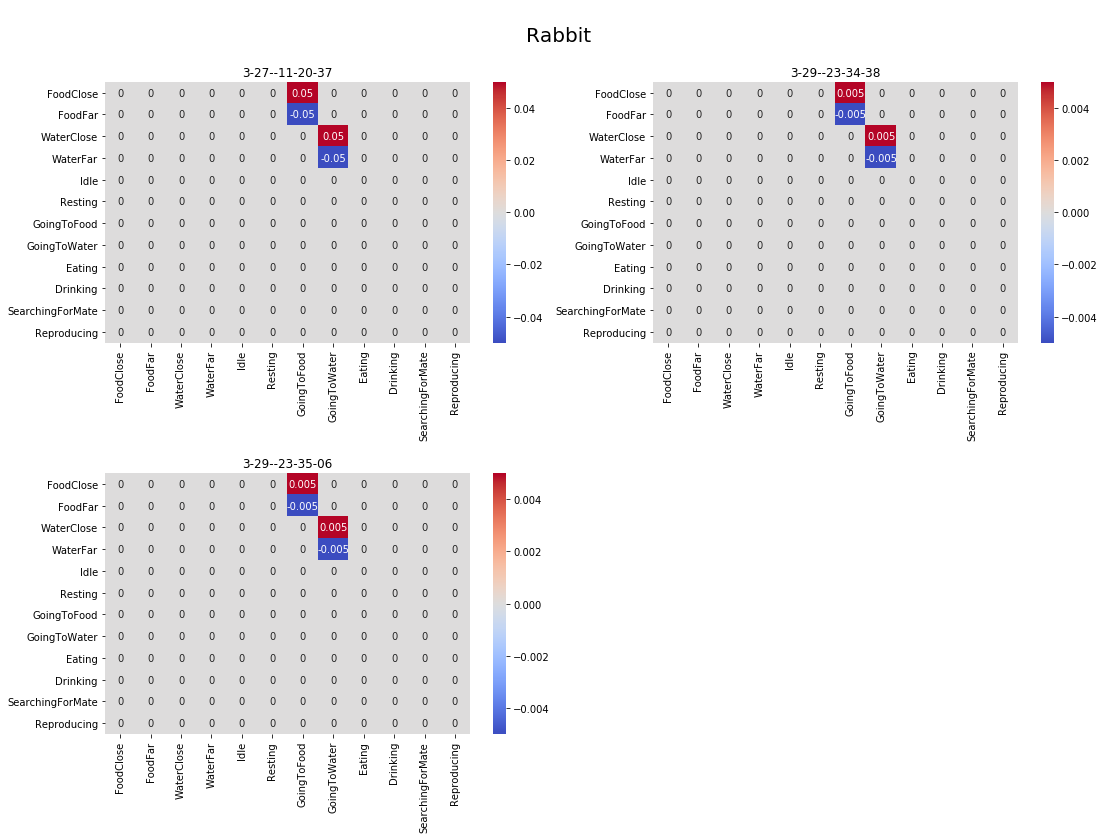

In [6]:

# plot fcm
for s in species:
    n_cols = 2
    n_rows = int((len(fcm_dataframes[s]) / n_cols) + 0.5)
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, 6 * n_rows))
    fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20) 
    col = 0
    row = 0
    for fcm in fcm_dataframes[s]: 
        #read csv
        data = fcm[0]
        #Make it display the fields in the same way as they are listed in EntityField
        data['from'] = pd.Categorical(data['from'], data['from'].unique())
        data['to'] = pd.Categorical(data['to'], data['to'].unique())


        data = data.pivot('from', 'to', 'weight')
        if n_rows > 1:
            _ax = axes[row][col]
        else:
            _ax = axes[col]
        ax = sns.heatmap(data,center=0, annot=True, cmap="coolwarm", ax=_ax)#,vmin=-1, vmax=1)
        ax.set_title(fcm[1])
        ax.set_ylabel('')
        ax.set_xlabel('')
        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = ax.get_ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        ax.set_ylim([b,t]) # update the ylim(bottom, top) values
        
        col += 1
        if col % 2 == 0:
            col = 0
            row += 1
    
    if col == 1:
        if n_rows > 1:
            axes[row][col].axis('off')
        else:
            axes[col].axis('off')
    
    plt.subplots_adjust(hspace=0.5)
    
    if export:
        fig.savefig(folder + "/" + s)
        



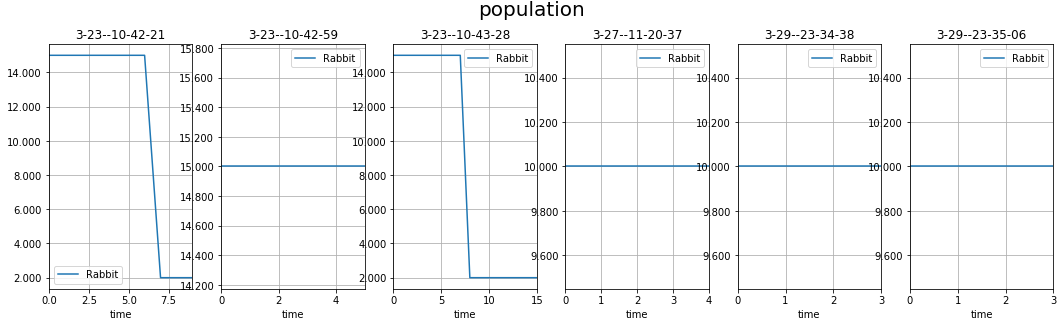

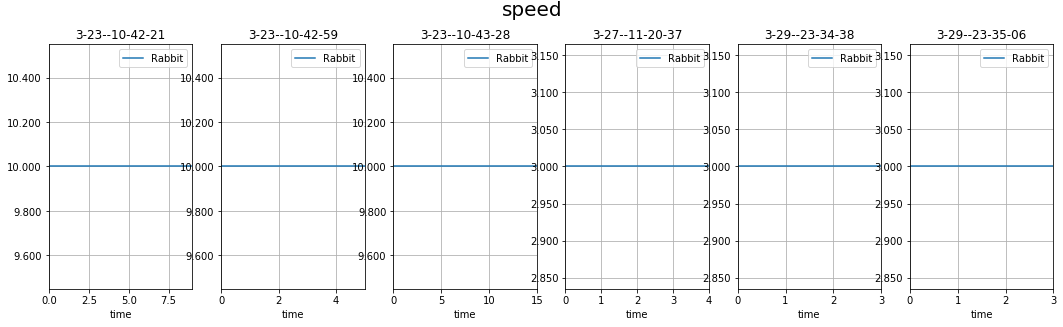

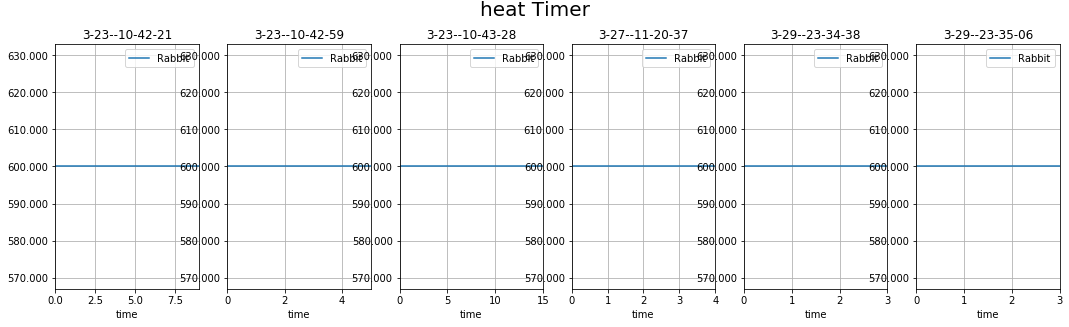

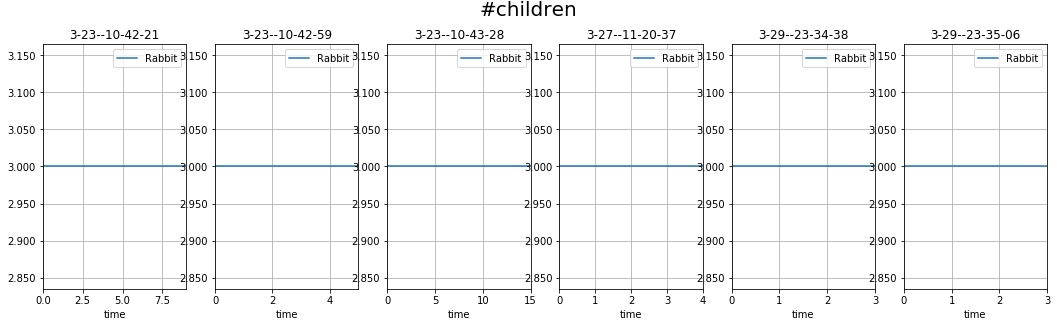

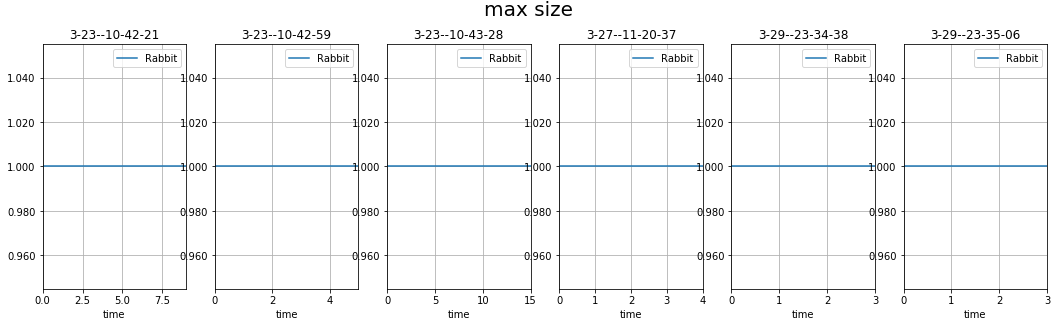

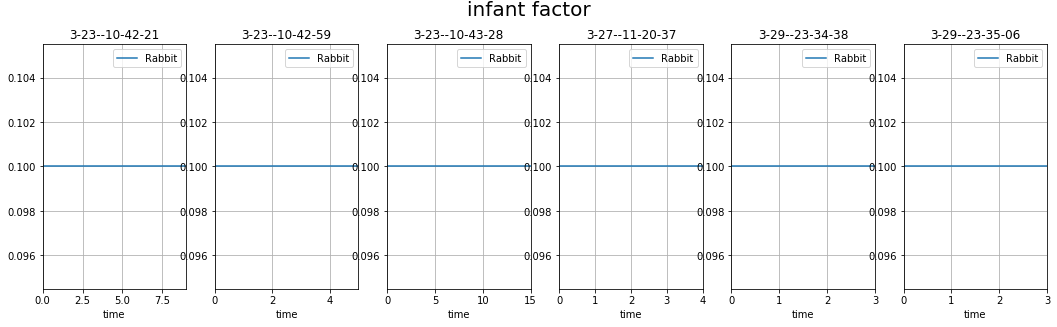

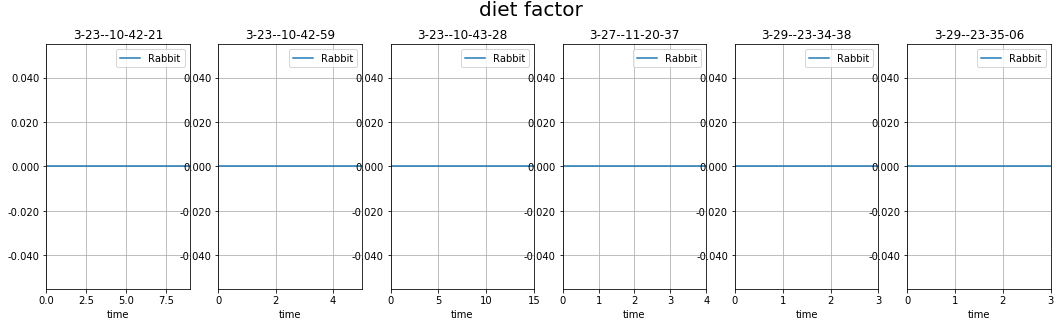

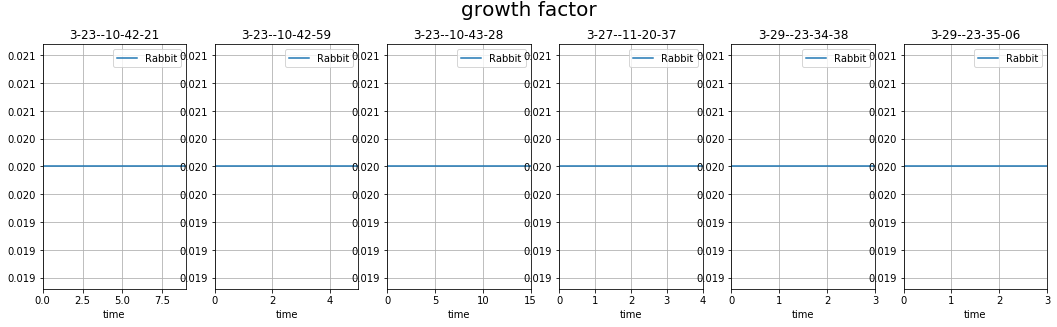

In [7]:
# plot traits grouped by trait and simulation
for t in traits:
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,4.5))
    fig.get_axes()[0].annotate(t,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for df in dataframes:
        ax = None
        legend = []
        for s in species:
            col = s + '-' + t
            # if e.g Rabbit-speed existed in this simulation, then plot it
            if col in df[0].columns:
                ax = df[0].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=axes[counter])
                legend.append(s)
                ax.set_xlabel("time")
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                counter += 1
        # if the the simulation had this trait, then fix legend name
        if len(legend) > 0:
            ax.legend(legend)
    if export:
        fig.savefig(folder + "/" + t)

In [8]:
"""
# plot fcm
for s in species:
    
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))
    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for fcm in fcmJsons:

        if fcm[2] == s:
            G = nx.DiGraph(directed=True)
            for entry in fcm[0]['weights']:
                G.add_weighted_edges_from([(entry['from'], entry['to'], entry['weight'])])

            edge_labels=dict([((u,v,),d['weight'])
                             for u,v,d in G.edges(data=True)])

            pos=nx.planar_layout(G)
            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color='black', ax = axes[counter], title = fcm[1])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])
            axes[counter].set_xticklabels([])
            axes[counter].set_yticklabels([])
            axes[counter].set_title(fcm[1])
            counter += 1
    fig.suptitle(s, y = 0.97, size = 20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    if export:
        fig.savefig(folder + "/" + s)
"""

'\n# plot fcm\nfor s in species:\n    \n    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))\n    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords=\'figure fraction\', ha=\'center\',fontsize=20)\n    counter = 0\n    for fcm in fcmJsons:\n\n        if fcm[2] == s:\n            G = nx.DiGraph(directed=True)\n            for entry in fcm[0][\'weights\']:\n                G.add_weighted_edges_from([(entry[\'from\'], entry[\'to\'], entry[\'weight\'])])\n\n            edge_labels=dict([((u,v,),d[\'weight\'])\n                             for u,v,d in G.edges(data=True)])\n\n            pos=nx.planar_layout(G)\n            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color=\'black\', ax = axes[counter], title = fcm[1])\n            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])\n            axes[counter].set_xticklabels([])\n            axes[counter].set_yticklabels([])